## Dataset preparation

In [1]:
#pip install -e .
#pip install  abbyy_course_cvdl_t2

from pathlib import Path
from course_ocr_t1.data import MidvPackage
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import wandb

import torch

from task1pack.utils.data import HeatmapDataset

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(42)

In [3]:
DATASET_PATH = Path() / '..' / '..' / 'data' / 'midv500_compressed'
#DATASET_PATH = Path() / '..' / '..' / '..' / '..' / '..' / '..' / 'Downloads' / 'midv500_compressed'
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

# Собираем список пакетов (MidvPackage) 
data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)
len(data_packs), type(data_packs[0])

(50, course_ocr_t1.data.MidvPackage)

In [4]:
from torchvision.transforms import Resize, Compose, ToTensor

IMAGE_SIZE = [416, 416]
HEATMAP_SIZE = [104, 104]

transforms = Compose([
    ToTensor(),
    Resize(IMAGE_SIZE),
])

train_dataset = HeatmapDataset(data_packs=data_packs, split='train', transforms=transforms, output_size=HEATMAP_SIZE)
test_dataset = HeatmapDataset(data_packs=data_packs, split='test', transforms=transforms, output_size=HEATMAP_SIZE)

print(len(train_dataset), len(test_dataset))
print(train_dataset[0][0].shape, train_dataset[0][1].shape)

10750 4250
torch.Size([3, 416, 416]) torch.Size([4, 2])


## Experiment

In [5]:
from task1pack.models.centernet import CenterNet

from task1pack.utils.train import train_model, show_train_plots

from torch.nn import MSELoss

In [6]:
centernet = CenterNet(pretrained="resnet34", head_kwargs={'c_classes': 4})

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
model_name = 'CenterNet'

train_dataloader_config = {
    'batch_size': 8,
    'shuffle': True,
}

test_dataloader_config = {
    'batch_size': 8,
    'shuffle': False,
}

training_config = {
    'lr': 1e-3,
    'epochs': 100,
    'step_size': 15,
    'gamma': 0.1,
}

device = 'cuda:0'
criterion = MSELoss()

wandb.init(
    project='ocr task 1',
    name='{} {} epochs with lr={}'.format(model_name, training_config['epochs'], training_config['lr']),
    config={
        'train_dataloader_config': train_dataloader_config,
        'test_dataloader_config': test_dataloader_config,
        'training_config': training_config,

    "architecture": model_name,
    "dataset": "MIDV-500",
    "criterion": "MSELoss",
    "optimizer": "Adam",
    "image_size": IMAGE_SIZE,
    "heatmap_size": HEATMAP_SIZE,    
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vashchilkoav. Use `wandb login --relogin` to force relogin


In [10]:
train_losses, test_losses, trained_model = train_model(
    train_dataset=train_dataset, 
    test_dataset=test_dataset, 
    model=centernet, 
    train_dataloader_kwargs=train_dataloader_config, 
    test_dataloader_kwargs=test_dataloader_config, 
    training_kwargs=training_config,
    criterion=criterion,
    device=device,
    wandb_instance=wandb,
)

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


initial loss 0.11510152369737625
epoch 0 started
train loss: 0.02921081917641762, test_loss: 0.01933412067592144
epoch 1 started
train loss: 0.02009017217919574, test_loss: 0.010490831919014454
epoch 2 started
train loss: 0.016959983885715787, test_loss: 0.00954030454158783
epoch 3 started
train loss: 0.016453158198817704, test_loss: 0.010955075733363628
epoch 4 started
train loss: 0.016638709820697494, test_loss: 0.08316659927368164
epoch 5 started
train loss: 0.018109165780818632, test_loss: 0.009095562621951103
epoch 6 started
train loss: 0.014321827599165513, test_loss: 0.008373656310141087
epoch 7 started
train loss: 0.01442148016914351, test_loss: 0.010506569407880306
epoch 8 started
train loss: 0.013657078226970043, test_loss: 0.008272064849734306
epoch 9 started
train loss: 0.013508215816121568, test_loss: 0.009018531069159508
epoch 10 started
train loss: 0.013125118097074543, test_loss: 0.00816868245601654
epoch 11 started
train loss: 0.012850391745641468, test_loss: 0.0073106

train loss: 0.009290513406973505, test_loss: 0.0071427891962230206


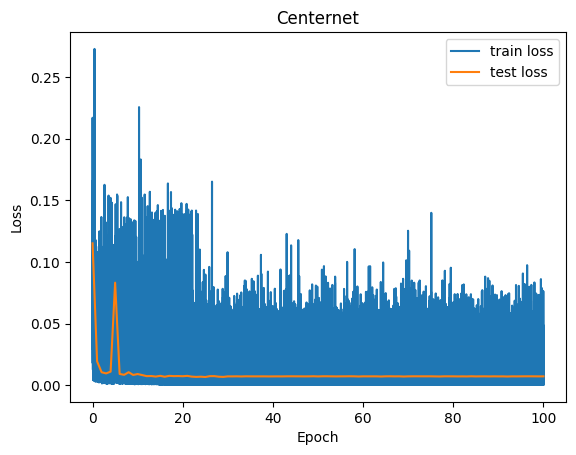

In [11]:
show_train_plots(train_losses, test_losses, 'Centernet')

### Сохраним результаты и измерим точность
Результаты - словарь с ключем DataItem.unique_key() и значением предсказанным quadrangle в относительных единицах.

In [12]:
from course_ocr_t1.metrics import dump_results_dict, measure_crop_accuracy

results_dict = {}

trained_model.eval()

with torch.no_grad():
    for i, (x, _) in tqdm(enumerate(test_dataset)):
        result = trained_model(x[None, ...].to(device))[0]
        key = test_dataset.get_key(i)
        results_dict[key] = result.cpu().tolist()

dump_results_dict(results_dict, Path() / 'pred.json')

acc_95 = measure_crop_accuracy(
    Path() / 'pred.json',
    Path() / 'gt.json'
)

acc_80 = measure_crop_accuracy(
    Path() / 'pred.json',
    Path() / 'gt.json',
    iou_thr=0.8
)

wandb.run.summary['acc@95'] = acc_95
wandb.run.summary['acc@80'] = acc_80

torch.save(trained_model.state_dict(), Path() / 'model.pth')
wandb.save(str(Path() / 'model.pth'))
wandb.save(str(Path() / 'pred.json'))

wandb.finish()

4250it [02:09, 32.78it/s]
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in inte

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.inte

acc@80,0.83953
acc@95,0.08306
